In [23]:
!pip install pypulseq==1.3.1.post1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

Syntaxfehler.
Syntaxfehler.
Syntaxfehler.


In [24]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'exD01_bSSFP_2D'

(bSSFP_2D_seq)=
# 2D bSSFP

Timing check passed successfully


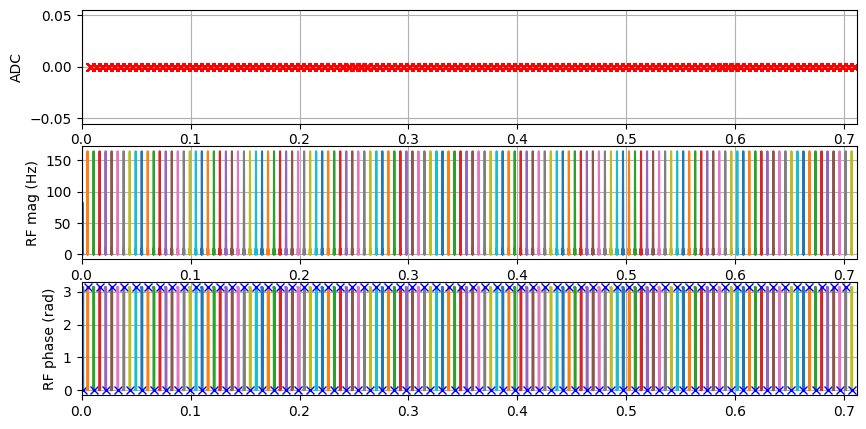

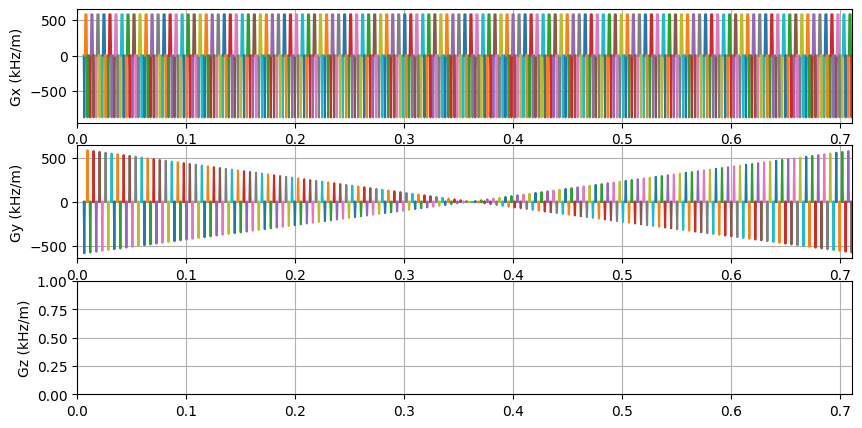

In [25]:
# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6
)


# %% S2. DEFINE the sequence
seq = pp.Sequence()

# Define FOV and resolution
fov = 220e-3
slice_thickness = 8e-3
sz = (32, 32)   # spin system size / resolution
Nread = 128    # frequency encoding steps/samples
Nphase = 128    # phase encoding steps/samples

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=15 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)
rf0, _, _ = pp.make_sinc_pulse(
    flip_angle=15 / 2 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=1e-3, system=system)
adc = pp.make_adc(num_samples=Nread, duration=1e-3, phase_offset=0 * np.pi / 180, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

rf_phase = 180
rf_inc = 180

# ======
# CONSTRUCT SEQUENCE
# ======
sdel = 1e-0

seq.add_block(rf0)
seq.add_block(pp.make_delay(3e-3))

for ii in range(-Nphase // 2, Nphase // 2):  # e.g. -64:63

    rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase

    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
    # increment additional pahse
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

    seq.add_block(rf1)
    gp = pp.make_trapezoid(channel='y', area=ii / fov, duration=1e-3, system=system)
    seq.add_block(gx_pre, gp)
    seq.add_block(adc, gx)
    gp = pp.make_trapezoid(channel='y', area=-ii / fov, duration=1e-3, system=system)
    seq.add_block(gx_pre, gp)


# %% S3. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# PLOT sequence
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, figid=(11,12))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write(experiment_id + '.seq')

In [46]:
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
# (i) load a phantom object from file
# obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
# obj_p = obj_p.interpolate(sz[0], sz[1], 1)
obj_p = mr0.VoxelGridPhantom.brainweb("subject05.npz").interpolate(128, 128, 32).slices([15])
# Manipulate loaded data
# obj_p.T2dash[:] = 30e-3
# obj_p.D *= 0
#@markdown alter the B0 inhomogeneity
dB0 = 1  #@param {type: "slider", min: 0, max: 10}
obj_p.B0 *= dB0
# Store PD and B0 for comparison
PD = obj_p.PD
B0 = obj_p.B0
# obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


def phantom_motion(time: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
    time /= seq.duration()[0]

    time[:] = 1
    phi = 0 * time
    x = 0.05 * time
    y = 0 * time

    phi = torch.as_tensor(phi)
    cos = torch.cos(phi)
    sin = torch.sin(phi)

    # We can't construct tensors directly as this would remove gradients
    offset = torch.zeros(time.numel(), 3)
    offset[:, 0] = x
    offset[:, 1] = y

    rot = torch.zeros(time.numel(), 3, 3)
    rot[:, 0, 0] = cos
    rot[:, 0, 1] = sin
    rot[:, 1, 0] = -sin
    rot[:, 1, 1] = cos
    rot[:, 2, 2] = 1

    return rot, offset


obj_p.phantom_motion = phantom_motion


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
# seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=True)

D:\repos\MRzero-Core\python\MRzeroCore\phantom\voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


Calculating repetition 62 / 129

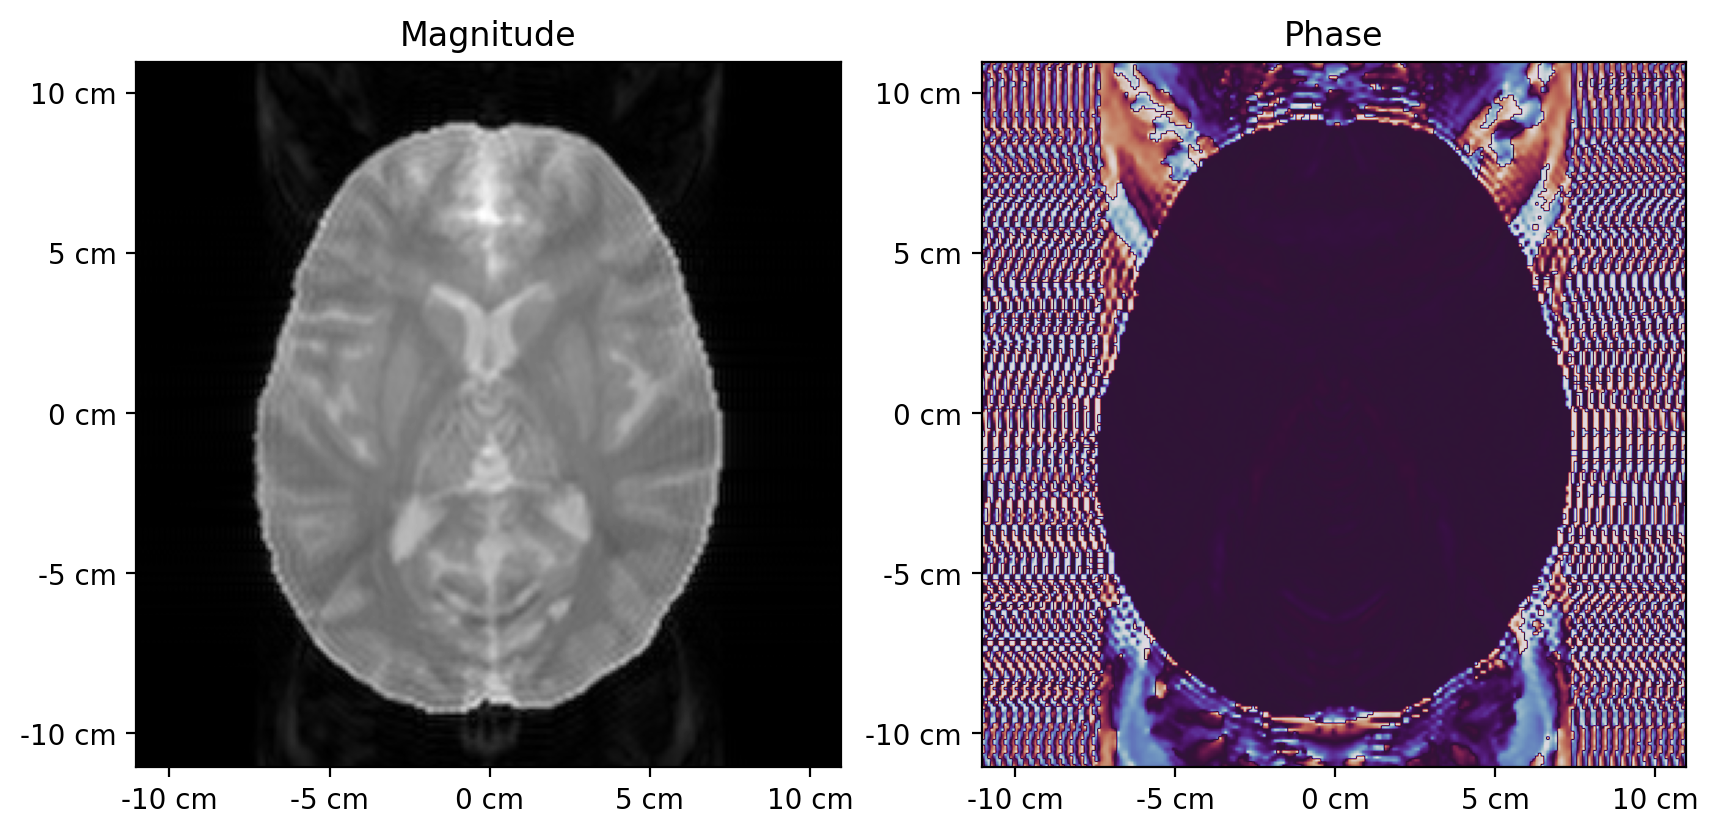

In [ ]:
# PLOT
fov = 0.22

def si(x):
    return (x / fov + 0.5) * 256

reco = mr0.reco_adjoint(signal, seq0.get_kspace(), (256, 256, 1), (fov, fov, 1))[:, :, 0]

plt.figure(figsize=(10, 5), dpi=200)
plt.subplot(121)
plt.title("Magnitude")
plt.imshow(reco.abs().cpu().T, origin='lower', vmin=0, cmap="gray")
plt.xticks([si(-0.1), si(-0.05), si(0), si(0.05), si(0.1)], ["-10 cm", "-5 cm", "0 cm", "5 cm", "10 cm"])
plt.yticks([si(-0.1), si(-0.05), si(0), si(0.05), si(0.1)], ["-10 cm", "-5 cm", "0 cm", "5 cm", "10 cm"])
plt.subplot(122)
plt.title("Phase")
plt.imshow(reco.angle().cpu().T, origin='lower', vmin=-torch.pi, vmax=torch.pi, cmap="twilight")
plt.xticks([si(-0.1), si(-0.05), si(0), si(0.05), si(0.1)], ["-10 cm", "-5 cm", "0 cm", "5 cm", "10 cm"])
plt.yticks([si(-0.1), si(-0.05), si(0), si(0.05), si(0.1)], ["-10 cm", "-5 cm", "0 cm", "5 cm", "10 cm"])
plt.show()

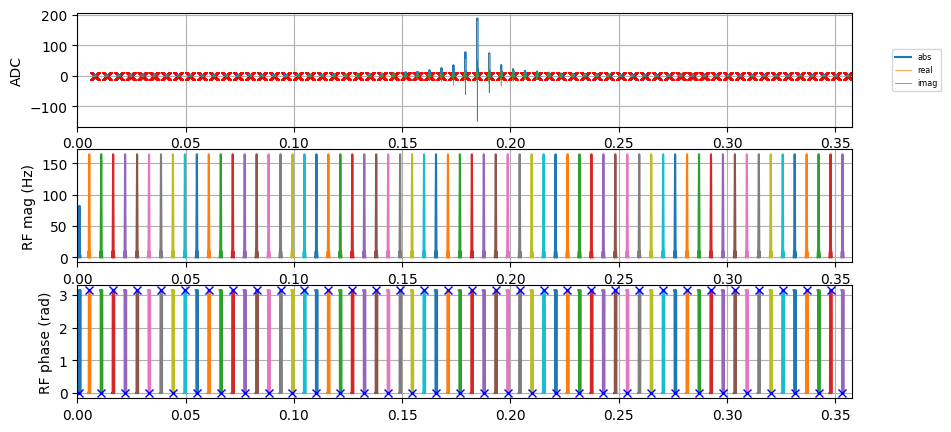

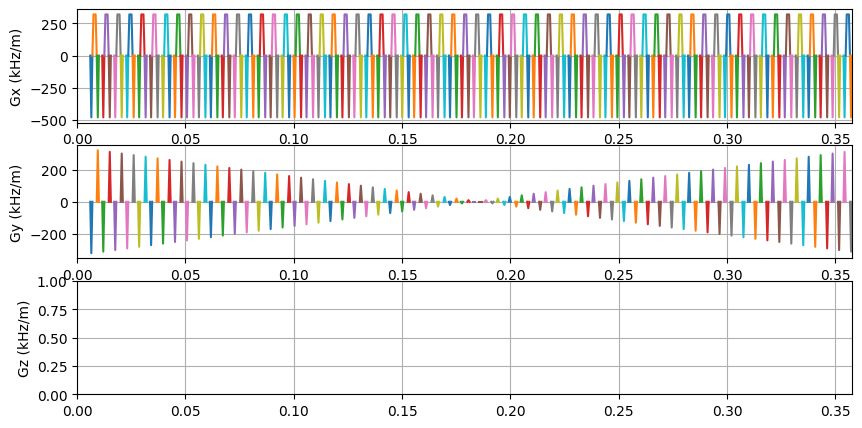

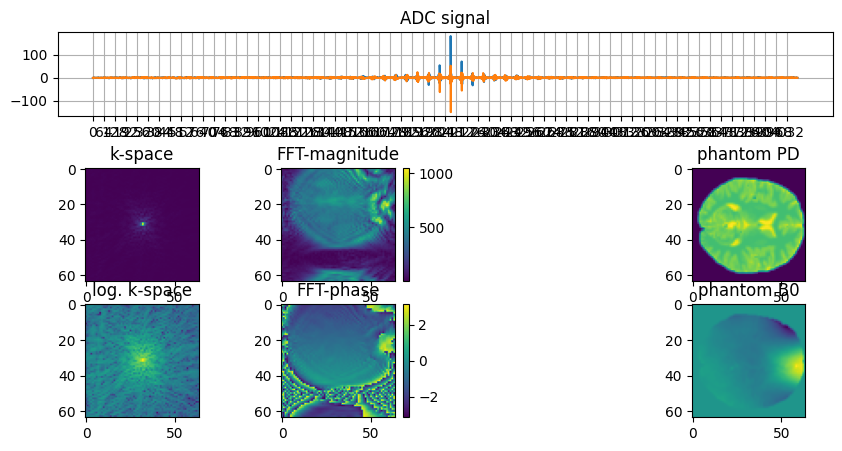

In [ ]:
# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, signal=signal.numpy())


# additional noise as simulation is perfect
signal += 1e-4 * np.random.randn(signal.shape[0], 2).view(np.complex128)


# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure()  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
plt.plot(torch.real(signal), label='real')
plt.plot(torch.imag(signal), label='imag')

# this adds ticks at the correct position szread
major_ticks = np.arange(0, Nphase * Nread, Nread)
ax = plt.gca()
ax.set_xticks(major_ticks)
ax.grid()

# fftshift
spectrum = torch.fft.fftshift(kspace)
# FFT
space = torch.fft.fft2(spectrum)
# fftshift
space = torch.fft.ifftshift(space)


plt.subplot(345)
plt.title('k-space')
plt.imshow(np.abs(kspace.numpy()))
plt.subplot(349)
plt.title('log. k-space')
plt.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(346)
plt.title('FFT-magnitude')
plt.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title('FFT-phase')
plt.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title('phantom PD')
plt.imshow(PD)
plt.subplot(3, 4, 12)
plt.title('phantom B0')
plt.imshow(B0)

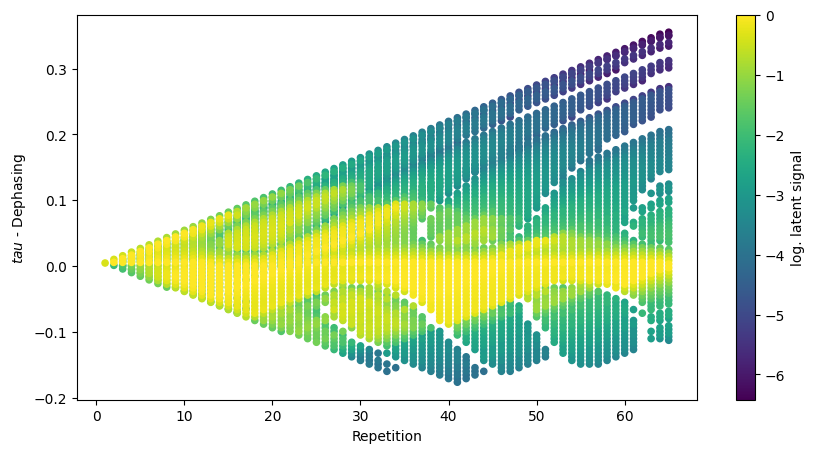

In [ ]:
#@title Plot the Phase Distribution Graph

plt.figure()
graph.plot(dephasing="tau", color="latent signal")
plt.show()